# Agent Based Discrete Event Simulations of Markets under Different Market Trends
## 1. Project Overview & Research Questions

This notebook implements an agent-based, Discrete Event Simulation (DES) of a single asset in a financial market, utilizing the idea of the Limit Order Book (LOB).

The objective to study how **market efficiency and liquduity** changes under different market conditions when **zero intelligence traders** interact with one another. Market conditions are dependent on the varying of arrival rates of buyers and sellers.

Key outputs include bid–ask spreads, queue sizes, order waiting times, fill rates, and confidence intervals constructed using multiple independent simulation runs with Common Random Numbers (CRN).

In [68]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heapq
import simpy
import scipy.stats as st

In [69]:
class Distribution:
    """
    Distributions class will be used for random variate generation
    """
    def __init__(self, sampler):
        self.sampler = sampler

    def sample(self):
        return self.sampler()

### 2. Agents
Agents are split into buyers and sellers.

- Price: Agents are 'zero intelligence' as their price is based solely on random noise around the prevailing market price. 
- Arrival: Buyers and sellers arrive at separate arrival rates based on their random variate from an exponential distribution with varying lambda's based on intention of study
- Assumptions: We assume that each new arrival to the market is a new individual who makes an order and does not ever cancel a trade (which is a big assumption of this study and will be improved in later versions). 

In [70]:
class Order:
    def __init__(self,order_id, investor_id, price, time, side):
        """
        Attrbiutes:
        investor_id: Unique identifier for the investor placing the order
        price: The price at which the order is placed
        time: The timestamp when the order is placed
        side: 'buy' or 'sell' indicating the type of order
        execution_time: is going to associated the time it takes for an order to take place once entered the LOB
        is_filled: is a binary variable which changes once an order has been made
        """
        self.id = order_id
        self.investor_id = investor_id
        self.price = price
        self.time = time
        self.side = side
        self.exeuction_time =  None
        self.is_filled = False


In [71]:
class Investor:
    """
    Attributes:
    - id: Unique identifier for the investor
    - price_dist: Distribution object for price noise
    - arrival_dist: Distribution object for inter-arrival times
    Methods:
    - get_valuation(orderbook): returns the valuation of the investor based on the order book
    - map_price(val, noise): maps the valuation and noise to a price (to be implemented in subclasses)
    - generate_price(orderbook): generates a price based on valuation and noise

    Overview:
    An investor is a parent class to buyers and sellers.
    Each investor comes to the queue with their ID (used as an identifier), a price and an arrival time.
    """
    def __init__(self, id, price_dist, arrival_dist): # investors have an id, price, and interarrival time 
        self.id = id
        self.price_dist = price_dist # this price distribution is the level of noise (or belief) relative to the fundamental price
        self.arrival_dist = arrival_dist

    def get_valuation(self, orderbook): # get the fundamental price through the method from the orderbook get midpoint price
        return (orderbook.best_ask() + orderbook.best_bid()) / 2 if orderbook.best_bid() is not None and orderbook.best_ask() is not None else orderbook.p0

    def map_price(self, val, noise):
        raise NotImplementedError

    def generate_price(self, orderbook):  # generate the price by the fundamental price and the noise 
        noise = self.price_dist.sample() # sample from the noise price distribution
        val = self.get_valuation(orderbook) # get the value of the fundamental price
        return round(self.map_price(val, noise), 2)
    
class Buyer(Investor):
    def map_price(self, val, noise): # each buyer is an investor type
        return val + noise

    def run(self, env, orderbook):
        while True: # while there are events in the buyer list
            yield env.timeout(self.arrival_dist.sample()) # wait until a sampled arrival distribution has taken place then proceed to have orders go through the simulaiton
            price = self.generate_price(orderbook) # generate a price
            order_id = orderbook.next_order_id() # create the order id
            order = Order(order_id,self.id, price, env.now, "buy") # add the order to the order book
            orderbook.add_order(order)

class Seller(Investor):
    def map_price(self, val, noise):
        return val + noise

    def run(self, env, orderbook):
        while True:
            yield env.timeout(self.arrival_dist.sample()) # wait until a sampled arrival distribution has taken place then proceed to have orders go through the simulation
            price = self.generate_price(orderbook) # generate a price
            order_id = orderbook.next_order_id()  # create the order id
            order = Order(order_id,self.id, price, env.now, "sell") # add the order to the order book
            orderbook.add_order(order)

### 3. Limit Order Book
The LOB is implements as a double sided priority queue:
- Buy orders are stored in a max-heap (highest price, earliest time priority)
- Sell orders are stored in a min-heap (lowest price, earliest time priority)

Orders are matched immediately upon arrival if they cross the spread with no service time, so execution occurs at the same time as trade acceptance.

In [72]:
class OrderBook:
    """
    Attributes:
    - p0: initial price of the asset
    - bids: list of buy orders (max heap)
    - asks: list of sell orders (min heap)
    - best_bid_list: list to track best bid prices over time which is important for calculating midpoint and spread
    - best_ask_list: list to track best ask prices over time
    - all_bids: list to track all bid prices for analysis, trades are met instantly so we need to keep track of all bids
    - all_asks: list to track all ask prices for analysis
    - trade_history: list of executed trades
    - next_order_id_counter: counter to assign unique order IDs
    - orderbook_history: list to track the state of the order book over time at each event clock advancement
    - all_orders: list to keep track of all orders for wait time calculations
    
    Methods:
    - best_bid(): returns the highest bid price
    - best_ask(): returns the lowest ask price
    - compute_wait_times(current_time): computes wait times for all orders
    - record_state(current_time): records the current state of the order book
    - add_order(order): adds an order to the order book
    - _process_buy(order): processes a buy order
    - _process_sell(order): processes a sell order
    - pct_filled(): returns the percentage of orders that have been filled
    - next_order_id(): generates the next unique order ID

    """
    def __init__(self,p0): 
        self.p0 = p0 # initial fundamental price of a product
        self.bids = []  # max heap - priority queue 
        self.asks = []  # min heap - priority queue of asks
        self.best_bid_list = []
        self.best_ask_list = []
        self.all_bids = []
        self.all_asks = []
        self.trade_history = [] 
        self.next_order_id_counter = 0
        self.orderbook_history = [] 
        self.all_orders = []

        
    """
    The following functions are made to keep track of how the orderbook progresses with time
    """
    def best_bid(self): # simply look at the minimum of the negative (largest prices of the bid queue)
        current_best_bid = -self.bids[0][0] if self.bids else None 
        self.best_bid_list.append(current_best_bid) 
        return current_best_bid

    def best_ask(self):  # look at the minimum of the seller ask prices
        current_best_ask = self.asks[0][0] if self.asks else None
        self.best_ask_list.append(current_best_ask) 
        return current_best_ask
    
    def compute_wait_times(self,current_time): # we want to compute wait times
        completed_wait_times = []
        current_wait_times = []
        total_wait_time = []
        for o in self.all_orders:
            if o.is_filled:
                completed_wait_times.append(o.execution_time - o.time)
            else:
                current_wait_times.append(current_time - o.time)
            total_wait_time.append(current_time - o.time if not o.is_filled else o.execution_time - o.time)
        return completed_wait_times,current_wait_times,total_wait_time
    
    def record_state(self, current_time): 
        completed_wait_times, ongoing_wait_times,total_wait_time = self.compute_wait_times(current_time)
        bid = self.best_bid()
        ask = self.best_ask()
        mid = (bid + ask) / 2 if bid is not None and ask is not None else None # need to keep track for price generation
        spread = ask - bid if bid is not None and ask is not None else None

        snapshot = { # takes a snapshot of the LOB through time
            "time": current_time,
            "best_bid": bid,
            "best_ask": ask,
            "midpoint": mid,
            "spread": spread,
            "completed_wait_times":completed_wait_times,
            "ongoing_wait_times":ongoing_wait_times,
            "total_wait_times":total_wait_time,
            "bid_queue_size": len(self.bids),
            "ask_queue_size":len(self.asks),
            }
        self.orderbook_history.append(snapshot)
        
    def add_order(self, order): # add order to the limit order book with the information from the 'order' class
        if order.side == "buy":
            self._process_buy(order)
        else:
            self._process_sell(order)
        self.all_orders.append(order)
        self.record_state(order.time) # record the state at the end of each order added as this is the only time that changes happen to the orderbook
    

    def _process_buy(self, order): # buy agents actions
        self.all_bids.append((order.price,order.time))
        while self.asks and (order.price >= self.best_ask()): # assuming that asks exist and the price is greater than the best ask then execute trade
            best_ask_price, time, oid, ask_order = heapq.heappop(self.asks) # we take the highest priority from the ask and assume there trade has been matched by the buyers
            
            ask_order.is_filled = True # the ask order is the one that is sitting in the queue 
            ask_order.execution_time = order.time

            order.is_filled = True  # the order is the new order which matches the ask order 
            order.execution_time = order.time

            self.trade_history.append((best_ask_price, time, ask_order)) # add this trade to the trade history
            return 

        # if there is no match then push the order to the bids
        heapq.heappush(self.bids, (-order.price, order.time, order.id, order))

    def _process_sell(self, order):
        self.all_asks.append((order.price,order.time))
        while self.bids and (order.price <= self.best_bid()): # assuming that bids exist and the price is less than the best bid then execute trade
            best_bid_price, time, oid, bid_order = heapq.heappop(self.bids) # we take the highest priority from the bid and assume there trade has been matched by the sellers
            best_bid_price = -best_bid_price # take the negative for the actual price due to heapq properties finding minimum
            bid_order.is_filled = True
            bid_order.execution_time = order.time

            order.is_filled = True
            order.execution_time = order.time
            self.trade_history.append((best_bid_price, time, bid_order)) # add to trade history
            return
        # if there is no match then the order to the asks pile
        heapq.heappush(self.asks, (order.price, order.time, order.id, order))

    def pct_filled(self):
        filled = sum(o.is_filled for o in self.all_orders)
        return filled / len(self.all_orders)


    def next_order_id(self): # keep a counter of the number of orders that have entered the order book
        self.next_order_id_counter += 1
        return self.next_order_id_counter

### 4. Simulation Architecture

The simulation framework is designed to support multiple independent replications, allowing for statistically meaningful output analysis. Each replication represents a discrete-event market simulation with identical structural assumptions but independent stochastic realizations.

Each simulation replication proceeds as follows:

1. **Initialize the Market**
   - Set an initial fundamental price P_0
   - Initialize an empty limit order book with separate bid and ask priority queues.
   - Initialize the simulation clock at time zero.

2. **Define Price Noise**
   - Construct a bounded noise interval proportional to P_0
   - Buyer and seller prices are generated according to prevailing market price + U[-noise*P0,noise*P0]
   - This is representative of zero intelligence traders

3. **Initialize Random Seeds**
   - Each replication uses a unique random seed.
   - This ensures independence across replications while maintaining reproducibility.

4. **Generate Interarrival Times**
   - Buyer and seller arrivals follow independent exponential distributions with varying lambda's.
   - Interarrival times are sampled through a `Distribution` class and scheduled using a discrete-event simulation framework.

5. **Agent Arrival and Order Submission**
   - Upon arrival, an agent:
     - Observes the current best bid and best ask.
     - Computes the midpoint price.
     - Samples a noise term and generates a limit price.
   - Each order is timestamped and submitted to the order book as either a buy or sell order.

6. **Order Matching**
   - A buy order executes immediately if its price is greater than or equal to the best ask.
   - A sell order executes immediately if its price is less than or equal to the best bid.
   - Otherwise, the order is stored in the order book according to **price–time priority**.

7. **State Recording**
   - After each event, the order book state is recorded, including:
     - Best bid and best ask
     - Midpoint price and spread
     - Queue sizes on both sides
     - Completed, ongoing, and total wait times

8. **Simulation Termination**
   - The simulation runs for a fixed time horizon (e.g., six hours).
   - Final order book depth, trade history, and performance metrics are recorded.


In [73]:
def output_analysis_data(orderbook):
    """
    Purpose:
    Extracts and organizes data from the order book for analysis.
    Args:
    - orderbook: An instance of the OrderBook class containing the simulation data.
    Returns:
    A tuple containing:
    - time: List of timestamps for each event.
    - best_bids_ts: List of best bid prices over time.
    - best_asks_ts: List of best ask prices over time.
    - midpoint_ts: List of midpoint prices over time.
    - spread_ts: List of spreads over time.
    - completed_wait_times: List of average completed wait times over time.
    - ongoing_wait_times: List of average ongoing wait times over time.
    - total_wait_times: List of average total wait times over time.
    - bid_queue_size: List of bid queue sizes over time.
    - ask_queue_size: List of ask queue sizes over time.
    - all_bids_prices: List of all bid prices.
    - all_bids_times: List of timestamps for all bid prices.
    - all_asks_prices: List of all ask prices.
    - all_asks_times: List of timestamps for all ask prices.
    - all_trades_prices: List of all trade prices.
    - all_trades_times: List of timestamps for all trades.
    - orderbook_bids: List of final bid prices in the order book.
    - orderbook_asks: List of final ask prices in the order book.
    
    """
    # --- Time series snapshots at each event ---
    time = []
    best_bids_ts = []
    best_asks_ts = []
    midpoint_ts = []
    spread_ts = []
    completed_wait_times = []
    ongoing_wait_times = []
    total_wait_times = []
    bid_queue_size = []
    ask_queue_size = []
    orderbook_bids = []
    orderbook_asks = []

    for snapshot in orderbook.orderbook_history:
        time.append(snapshot['time'])
        best_bids_ts.append(snapshot['best_bid'])
        best_asks_ts.append(snapshot['best_ask'])
        midpoint_ts.append(snapshot['midpoint'])
        spread_ts.append(snapshot['spread'])

        cw = snapshot['completed_wait_times']
        ow = snapshot['ongoing_wait_times']
        tw = snapshot['total_wait_times']

        completed_wait_times.append(np.mean(cw) if len(cw) > 0 else np.nan)
        ongoing_wait_times.append(np.mean(ow) if len(ow) > 0 else np.nan)
        total_wait_times.append(np.mean(tw) if len(tw) > 0 else np.nan)

        bid_queue_size.append(snapshot['bid_queue_size'])
        ask_queue_size.append(snapshot['ask_queue_size'])


    # --- Full event-level bid/ask history ---
    all_bids_prices = [b[0] for b in orderbook.all_bids]
    all_bids_times  = [b[1] for b in orderbook.all_bids]

    all_asks_prices = [a[0] for a in orderbook.all_asks]
    all_asks_times  = [a[1] for a in orderbook.all_asks]

    # --- Trades ---
    all_trades_prices = [t[0] for t in orderbook.trade_history]
    all_trades_times  = [t[1] for t in orderbook.trade_history]

    # end of simulation order book
    for bids in orderbook.bids:
        orderbook_bids.append(-bids[0])
    for asks in orderbook.asks:
        orderbook_asks.append(asks[0])

    return (
        time,
        best_bids_ts, best_asks_ts, midpoint_ts, spread_ts,
        completed_wait_times, ongoing_wait_times, total_wait_times,
        bid_queue_size, ask_queue_size,
        all_bids_prices, all_bids_times,
        all_asks_prices, all_asks_times,
        all_trades_prices, all_trades_times,
        orderbook_bids, orderbook_asks
    )

In [74]:
def multiple_simulations(n_sims, p0,noise_lvl,buyer_arrival_rate,seller_arrival_rate,hours,minutes):
    """
    Run multiple simulations of the order book model utilizing SimPy for discrete-event simulation.
    Utilizes the Output Analysis function to extract and organize data from each simulation run.

    Parameters:
    - n_sims: Number of simulation runs to execute.
    - p0: Initial fundamental price of the asset.
    - noise_lvl: Level of noise to apply to the price distributions.
    - buyer_arrival_rate: Arrival rate for buyers (lambda parameter for exponential distribution).
    - seller_arrival_rate: Arrival rate for sellers (lambda parameter for exponential distribution).
    - hours: Number of hours to run each simulation.
    - minutes: Number of additional minutes to run each simulation.

    Output:
    A dictionary with each simulation run containing:
    - timeseries: DataFrame with time series data of best bids, best asks, midpoint, spread, wait times, and queue sizes.
    - extra: Dictionary with additional data including all bids, asks, trades, and final order book state.
    """

    simulation_runs = {}
    
    p0 = p0
    p0_min = -p0*noise_lvl
    p0_max = p0*noise_lvl


    for i in range(n_sims):
        np.random.seed(i)

        buyer_arrival_dist = Distribution(lambda:np.random.exponential(1/buyer_arrival_rate)) # we can adjust the arrival rate for the buyers
        seller_arrival_dist = Distribution(lambda: np.random.exponential(1/seller_arrival_rate)) # we can adjust the arrival rate for the sellers

        buyer_price_dist_noise = Distribution(lambda:round(np.random.uniform(p0_min,p0_max),2)) # we can adjust the noise for the buyers
        seller_price_dist_noise = Distribution(lambda:round(np.random.uniform(p0_min,p0_max),2)) # we can adjust the noise for the sellers
    
        env = simpy.Environment(0)
        orderbook = OrderBook(p0)

        buyer = Buyer('Buyer',buyer_price_dist_noise,buyer_arrival_dist)
        seller = Seller('Seller',seller_price_dist_noise,seller_arrival_dist)

        env.process(buyer.run(env,orderbook))
        env.process(seller.run(env,orderbook))

        time_elapsed = ((hours *60) + minutes)

        env.run(until=time_elapsed)

        time,best_bids_ts, best_asks_ts, midpoint_ts, spread_ts,completed_wait_times, ongoing_wait_times,total_wait_times,bid_queue_size, ask_queue_size,all_bids_prices, all_bids_times, all_asks_prices, all_asks_times, all_trades_prices, all_trades_times,orderbook_bids,orderbook_asks = output_analysis_data(orderbook)

        results = pd.DataFrame({
            "time": time,
            "best_bids": best_bids_ts,
            "best_asks": best_asks_ts,
            "midpoint": midpoint_ts,
            "spread": spread_ts,
            "completed_wait_times": completed_wait_times,
            "ongoing_wait_times": ongoing_wait_times,
            "total_wait_times":total_wait_times,
            "bid_queue_size": bid_queue_size,
            "ask_queue_size": ask_queue_size,
        },index=time)

        extra = {
            "all_bids_prices": all_bids_prices,
            "all_bids_times": all_bids_times,
            "all_asks_prices": all_asks_prices,
            "all_asks_times": all_asks_times,
            "all_trades_prices": all_trades_prices,
            "all_trades_times": all_trades_times,
            "final_orderbook_bids": orderbook_bids,
            "final_orderbook_asks": orderbook_asks,
            "order filled":orderbook.pct_filled()
        }


        simulation_runs[str(i)] = {
        "timeseries": results,
        "extra": extra
        }


    return simulation_runs

### 5. Single Simulation
With the simulation architecture setup the purpose of this chapter is to showcase what goes on under the hood for any given simulation run. 

For the output imagine each one of these occurs 30 times across in each category to get robust solutions that are not subject to noise from different random variates.

In [75]:
def plot_orderbook_metrics(
        time, best_bids, best_asks, midpoint,
        spread, comp_wait, ong_wait,
        bqsize, aqsize,
        bids_price, bids_time,
        asks_price, asks_time,
        trades_prices, trades_times,
        end_bids, end_asks
    ):

    fig = plt.figure(figsize=(10,12))

    # 4 rows, 2 columns → last row full width
    gs = fig.add_gridspec(4, 2)

    # PANEL 1 ‒ Best Bid / Ask / Mid
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(time, best_bids, label="Best Bid")
    ax1.plot(time, best_asks, label="Best Ask")
    ax1.plot(time, midpoint, label="Midpoint", linestyle="--")
    ax1.set_title("Best Bid / Best Ask / Midpoint")
    ax1.legend()
    ax1.grid(alpha=0.3)

    # PANEL 2 ‒ Completed wait
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(time, comp_wait)
    ax2.set_title("Completed Orders – Avg Wait Time")
    ax2.grid(alpha=0.3)

    # PANEL 3 ‒ Ongoing wait
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(time, ong_wait)
    ax3.set_title("Ongoing Orders – Avg Queue Wait Time")
    ax3.grid(alpha=0.3)

    # PANEL 4 ‒ Queue sizes
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(time, bqsize, label="Bid Queue Size")
    ax4.plot(time, aqsize, label="Ask Queue Size")
    ax4.set_title("Queue Size")
    ax4.legend()
    ax4.grid(alpha=0.3)

    # PANEL 5 ‒ All Bids/Asks/Trades
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.plot(bids_time, bids_price, color="green", label="All Bids")
    ax5.plot(asks_time, asks_price, color="red", label="All Asks")
    ax5.scatter(trades_times, trades_prices, s=10, color="orange", label="Trades")
    ax5.set_title("Bids, Asks, and Trades Through Time")
    ax5.legend()
    ax5.grid(alpha=0.3)

    # PANEL 6 is the Spread 
    ax6 = fig.add_subplot(gs[0, 1])
    ax6.plot(time, spread)
    ax6.set_title("Spread")
    ax6.grid(alpha=0.3)

    # PANEL 7 ‒ Big histogram across whole width
    ax7 = fig.add_subplot(gs[3, :])
    ax7.hist(end_bids, bins=20, alpha=0.6, label="Final Bids", color="green")
    ax7.hist(end_asks, bins=20, alpha=0.6, label="Final Asks", color="red")
    ax7.set_title("Final Limit Order Book Depth (Histogram)")
    ax7.set_xlabel("Price")
    ax7.set_ylabel("Frequency")
    ax7.legend()
    ax7.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [76]:
p0 = 100 # set a fundamental price for the market 
p0_min = -p0*0.02 # minimum noise
p0_max = p0*0.02 # maximum noise
hours = 6
minutes = 0

buyers_list = []
sellers_list = []

env = simpy.Environment(0) # initial start time of the simulation
orderbook = OrderBook(p0) # initialize the orderbook with fundamental price p0

buyer_arrival_dist = Distribution(lambda:np.random.exponential(1)) # we can adjust the arrival rate for the buyers
seller_arrival_dist = Distribution(lambda: np.random.exponential(1)) # we can adjust the arrival rate for the sellers

buyer_price_dist_noise = Distribution(lambda:round(np.random.uniform(p0_min,p0_max),2)) # we can adjust the noise for the buyers
seller_price_dist_noise = Distribution(lambda:round(np.random.uniform(p0_min,p0_max),2)) # we can adjust the noise for the sellers

env = simpy.Environment(0)
orderbook = OrderBook(p0)

buyer = Buyer('Buyer',buyer_price_dist_noise,buyer_arrival_dist)
seller = Seller('Seller',seller_price_dist_noise,seller_arrival_dist)

env.process(buyer.run(env,orderbook))
env.process(seller.run(env,orderbook))

time_elapsed = ((hours *60) + minutes)

env.run(until=time_elapsed)

time,best_bids_ts, best_asks_ts, midpoint_ts, spread_ts,completed_wait_times, ongoing_wait_times, total_wait_times,bid_queue_size, ask_queue_size,all_bids_prices, all_bids_times,all_asks_prices, all_asks_times,all_trades_prices, all_trades_times,orderbook_bids, orderbook_asks = output_analysis_data(orderbook)

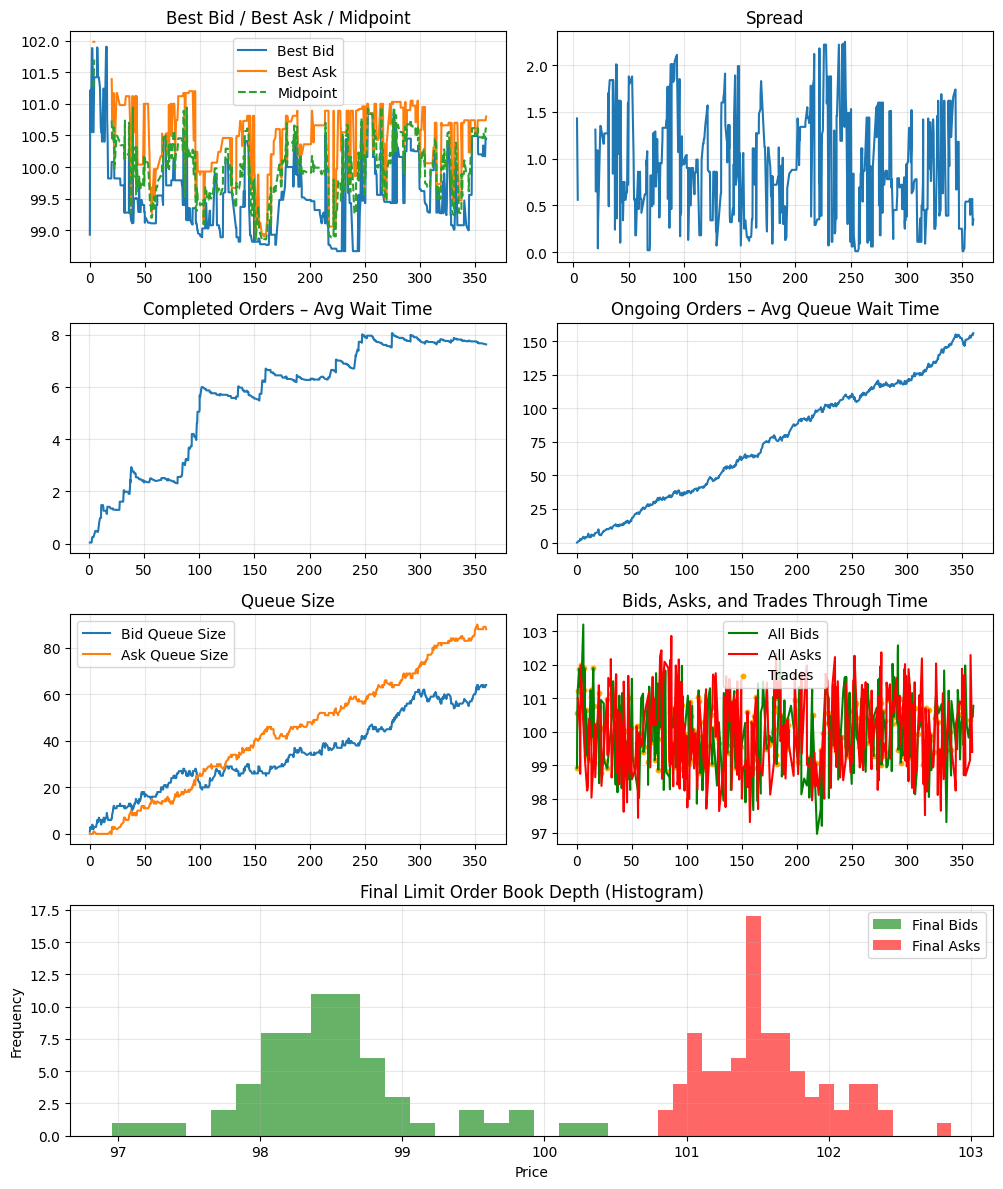

In [77]:
plot_orderbook_metrics(time,best_bids_ts, best_asks_ts, midpoint_ts, spread_ts,completed_wait_times, ongoing_wait_times,bid_queue_size, ask_queue_size,all_bids_prices, all_bids_times, all_asks_prices, all_asks_times, all_trades_prices, all_trades_times,orderbook_bids,orderbook_asks)

Major takeaways:
- Fundamental price: The price is able to effectively move around dependent on differing arrival rates to the market which is the result of a stochastic process
- Spread: Remains stationary
- Wait Times: A drawback from our assumption regarding non order cancellation becomes clear as time goes on those old orders continue to mount higher wait times. However those that are filled give a better indication of average wait time through time.
- Limit Order Book Histogram: Showcases what would be expected over a 6 hour period of the market with more bids/asks around the bid/ask spread and less moving away.

### 6. Simulate Market Events

We categorize neutral, bull, and bear markets given their underlying arrival rate to the market. This is a simple approach but is meant to showcase how the imapcts of supply and demand impact the price of the product.

- Neutral Market: 1 buyer for every 1 seller
- Bull Market: 1.5 buyers for every 1 seller
- Bear Market: 0.5 buyers for every 1 seller

Across these different markets we are able to draw conclusions about difference in market efficiency and pricing of the asset.

In [78]:
def output_simulation_results(simulation_runs):
    """
    This function takes the output from multiple_simulations and compiles a summary DataFrame.
    The summary includes average best bids, best asks, midpoints, spreads, wait times, queue sizes, and percentage of orders filled across all simulation runs.
    This allows for statistical analysis of the simulation results by averaging over multiple runs.
    """
    best_bids = []
    best_asks = []
    midpoints = []
    spreads = []
    completed_wt = []
    ongoing_wt = []
    total_wt = []
    bid_q = []
    ask_q = []
    pct_filled = []
    final_bids = []
    final_asks = []

    for i in range(len(simulation_runs)):
        df = simulation_runs[str(i)]['timeseries']
        df2 = simulation_runs[str(i)]['extra']

        best_bids.append(df['best_bids'].mean().round(2))
        best_asks.append(df['best_asks'].mean().round(2))
        midpoints.append(df['midpoint'].mean().round(2))
        spreads.append(df['spread'].mean().round(2))
        completed_wt.append(df['completed_wait_times'].mean().round(2))
        ongoing_wt.append(df['ongoing_wait_times'].mean().round(2))
        total_wt.append(df['total_wait_times'].mean().round(2))
        bid_q.append(df['bid_queue_size'].mean().round(2))
        ask_q.append(df['ask_queue_size'].mean().round(2))
        pct_filled.append(round(df2['order filled'],3))
        final_bids.append(df2['final_orderbook_bids'])
        final_asks.append(df2['final_orderbook_asks'])


    # build final summary table
    summary = pd.DataFrame({
        "best_bids": best_bids,
        "best_asks": best_asks,
        "midpoints": midpoints,
        "spreads": spreads,
        "completed_wait_times": completed_wt,
        "ongoing_wait_times": ongoing_wt,
        "total_wait_times": total_wt,
        "bid_queue_size": bid_q,
        "ask_queue_size": ask_q,
        "pct_filled": pct_filled,
    })

    summary_values = summary.mean()

    return summary,summary_values, final_bids, final_asks

In [79]:
# perform multiple simulations across each market type
simulation_results_neutral = multiple_simulations(30,100,0.02,1,1,6,0)
simulation_results_bull = multiple_simulations(30,100,0.02,1,0.5,6,0)
simulation_results_bear = multiple_simulations(30,100,0.02,0.5,1,6,0)

In [80]:
simulation_results_neutral['0']['timeseries']

,time,best_bids,best_asks,midpoint,spread,completed_wait_times,ongoing_wait_times,total_wait_times,bid_queue_size,ask_queue_size
0.795875,0.795875,100.41,NaN,NaN,NaN,NaN,0.000000,0.000000,1,0
1.255931,1.255931,NaN,NaN,NaN,NaN,0.230028,NaN,0.230028,0,0
1.583076,1.583076,99.75,NaN,NaN,NaN,0.230028,0.000000,0.153352,1,0
2.294090,2.294090,99.75,101.85,100.800,2.10,0.230028,0.355507,0.292768,1,1
2.777692,2.777692,99.75,101.85,100.800,2.10,0.230028,0.559406,0.427655,1,2
...,...,...,...,...,...,...,...,...,...,...
358.506939,358.506939,99.30,101.62,100.460,2.32,8.185290,166.257848,39.799801,90,50
358.961919,358.961919,99.30,101.62,100.460,2.32,8.295695,167.348042,39.833892,89,50
359.610582,359.610582,99.30,101.63,100.465,2.33,8.726140,167.334634,39.905587,89,49
359.629687,359.629687,99.24,101.63,100.435,2.39,8.784286,168.207685,39.852573,88,49


We showcase the time series for a single run as a result of the snapshot feature. 

In [81]:
simulation_results_runs_neutral = output_simulation_results(simulation_results_neutral)[0]
simulation_results_runs_bull = output_simulation_results(simulation_results_bull)[0]
simulation_results_runs_bear = output_simulation_results(simulation_results_bear)[0]

In [82]:
simulation_results_runs_neutral

,best_bids,best_asks,midpoints,spreads,completed_wait_times,ongoing_wait_times,total_wait_times,bid_queue_size,ask_queue_size,pct_filled
0,99.85,100.71,100.28,0.86,5.08,73.64,19.92,43.58,33.16,0.804
1,101.63,102.42,102.05,0.74,5.03,72.43,21.88,48.45,39.82,0.750
2,100.42,101.21,100.82,0.80,7.62,78.57,25.20,54.78,35.97,0.792
3,100.06,100.83,100.44,0.77,4.69,75.11,19.81,42.29,37.85,0.794
4,100.16,101.01,100.59,0.85,8.37,69.93,22.63,44.36,37.21,0.792
5,98.81,99.60,99.20,0.81,4.88,75.26,20.55,41.84,34.02,0.766
6,99.38,100.22,99.82,0.89,5.32,58.56,15.21,31.33,36.70,0.780
7,98.04,98.74,98.38,0.73,6.44,70.65,21.49,35.71,49.84,0.761
8,98.68,99.52,99.08,0.87,4.36,72.20,18.13,32.32,42.49,0.793
9,100.08,100.89,100.48,0.83,6.46,78.87,22.42,31.85,49.28,0.796


Showcasing the first 5 simulation runs of neutral market trend. Can observe the differing values across different simulations which showcases the importances of implementing the IID outputs.

### 7. Output Analysis
As we have IID outputs across replications statistical analyses such as confidence intervals can be created on our results.

In [83]:
simulation_results_runs_dict = {
    "neutral":simulation_results_runs_neutral,
    "bull":simulation_results_runs_bull,
    "bear":simulation_results_runs_bear
}

In [84]:
def confidence_intervals(data):
    mean = np.mean(data)
    standard_error = st.sem(data)
    ci = tuple(st.t.interval(0.95,len(data)-1,loc=mean,scale=standard_error))
    return ci

In [85]:
def simulation_results_across_parameters(sim_results_dict):
    """
    sim_results_dict:
        key: parameter label
        value: summary DataFrame containing metrics across replications
    """
    
    markets = list(sim_results_dict.keys())
    metrics = sim_results_dict[markets[0]].columns
    
    ci_df = pd.DataFrame(index=metrics, columns=markets)
    
    for market in markets:
        summary_df = sim_results_dict[market]
        
        for metric in metrics:
            data = summary_df[metric]
            ci_tuple = confidence_intervals(data)
            ci_df.loc[metric, market] = np.round(ci_tuple,3)
    
    return ci_df

In [86]:
results = simulation_results_across_parameters(simulation_results_runs_dict)
results

,neutral,bull,bear
best_bids,"[99.437, 100.412]","[101.513, 102.036]","[97.067, 97.601]"
best_asks,"[100.247, 101.206]","[102.393, 102.89]","[98.027, 98.442]"
midpoints,"[99.841, 100.812]","[101.984, 102.488]","[97.456, 97.975]"
spreads,"[0.79, 0.835]","[0.797, 0.859]","[0.766, 0.836]"
completed_wait_times,"[5.531, 6.401]","[4.576, 5.828]","[5.448, 6.813]"
ongoing_wait_times,"[72.058, 76.619]","[80.773, 85.429]","[79.05, 84.581]"
total_wait_times,"[20.048, 22.011]","[29.829, 32.818]","[30.214, 33.79]"
bid_queue_size,"[37.662, 44.432]","[84.386, 93.721]","[1.244, 1.925]"
ask_queue_size,"[35.147, 40.968]","[1.216, 1.868]","[85.518, 95.132]"
pct_filled,"[0.784, 0.798]","[0.66, 0.687]","[0.656, 0.682]"


### 8. Sensitivity Analysis
We noticed that changing the presence of buyers and sellers due to categorical differences are clear, however we are able to explore this through a numerical relationship - numBuyers / numSellers

In [87]:
simulation_results_neutral = multiple_simulations(30,100,0.02,1,1,6,0)

In [88]:
numBuyers = np.linspace(0.6,2,30)
# for each numbuyers ratio I want to create a multiple simulation run stored with the index as the ratio value in a dict
ratio_dict = {}
for i in numBuyers:
    ratio_dict[str(round(i,2))] = output_simulation_results(multiple_simulations(10,100,0.02,i,1,6,0))[0]

In [89]:
ratio_ci_results = simulation_results_across_parameters(ratio_dict)
ratio_ci_results

,0.6,0.65,0.7,0.74,0.79,0.84,0.89,0.94,0.99,1.03,...,1.57,1.61,1.66,1.71,1.76,1.81,1.86,1.9,1.95,2.0
best_bids,"[96.031, 97.833]","[95.834, 97.718]","[95.499, 97.491]","[95.232, 97.01]","[96.399, 98.077]","[96.936, 98.976]","[96.622, 98.954]","[97.277, 100.087]","[98.448, 100.96]","[98.906, 100.826]",...,"[102.004, 104.834]","[101.997, 103.947]","[101.986, 104.256]","[101.475, 103.643]","[101.424, 103.764]","[101.549, 102.737]","[101.386, 102.296]","[101.36, 101.964]","[101.742, 102.694]","[101.617, 102.101]"
best_asks,"[97.083, 98.699]","[96.905, 98.655]","[96.521, 98.473]","[96.167, 97.907]","[97.298, 98.89]","[97.812, 99.778]","[97.413, 99.763]","[98.135, 100.897]","[99.27, 101.81]","[99.696, 101.646]",...,"[103.037, 105.739]","[102.959, 104.941]","[103.034, 105.136]","[102.397, 104.549]","[102.374, 104.892]","[102.42, 103.892]","[102.178, 103.328]","[102.128, 103.16]","[102.713, 103.973]","[102.611, 103.107]"
midpoints,"[96.423, 98.197]","[96.23, 98.144]","[95.906, 97.908]","[95.632, 97.406]","[96.804, 98.482]","[97.354, 99.374]","[97.006, 99.356]","[97.699, 100.495]","[98.851, 101.397]","[99.3, 101.244]",...,"[102.631, 105.327]","[102.567, 104.533]","[102.632, 104.758]","[101.985, 104.171]","[101.968, 104.498]","[102.014, 103.488]","[101.804, 102.92]","[101.739, 102.761]","[102.307, 103.581]","[102.201, 102.691]"
spreads,"[0.718, 0.844]","[0.803, 0.895]","[0.794, 0.884]","[0.773, 0.863]","[0.768, 0.884]","[0.775, 0.869]","[0.743, 0.857]","[0.776, 0.894]","[0.794, 0.878]","[0.775, 0.853]",...,"[0.805, 0.877]","[0.776, 0.882]","[0.74, 0.884]","[0.76, 0.912]","[0.772, 0.896]","[0.776, 0.858]","[0.734, 0.842]","[0.732, 0.868]","[0.766, 0.86]","[0.798, 0.878]"
completed_wait_times,"[3.52, 5.138]","[4.503, 7.143]","[4.465, 6.335]","[4.465, 5.909]","[5.205, 7.545]","[5.057, 7.049]","[5.201, 7.007]","[4.732, 6.302]","[4.853, 5.935]","[4.846, 6.606]",...,"[3.396, 6.418]","[4.155, 5.585]","[3.655, 4.769]","[2.846, 5.22]","[3.831, 6.461]","[3.756, 6.424]","[3.093, 4.889]","[3.205, 4.443]","[3.438, 5.656]","[3.419, 4.769]"
ongoing_wait_times,"[79.234, 87.908]","[74.297, 84.925]","[72.574, 82.994]","[75.127, 85.631]","[73.755, 85.093]","[72.55, 79.322]","[70.345, 80.347]","[72.3, 82.146]","[72.342, 78.542]","[73.317, 77.577]",...,"[71.248, 86.18]","[74.62, 83.122]","[76.575, 86.229]","[76.306, 87.224]","[76.089, 84.407]","[74.032, 84.954]","[81.214, 89.524]","[81.577, 88.975]","[75.338, 86.098]","[79.452, 86.3]"
total_wait_times,"[25.86, 29.554]","[21.45, 27.71]","[20.247, 24.635]","[21.411, 24.967]","[20.877, 26.301]","[19.596, 22.896]","[18.935, 23.597]","[19.578, 23.722]","[18.825, 22.485]","[20.59, 22.978]",...,"[20.072, 25.056]","[21.129, 26.983]","[22.189, 26.605]","[22.087, 27.979]","[23.836, 30.396]","[24.47, 29.272]","[26.938, 32.358]","[27.602, 32.642]","[26.038, 32.806]","[27.098, 32.718]"
bid_queue_size,"[1.666, 6.228]","[2.034, 9.524]","[5.559, 13.959]","[8.385, 17.979]","[13.932, 25.77]","[18.553, 28.699]","[17.756, 29.624]","[25.866, 40.664]","[32.73, 44.03]","[43.841, 50.399]",...,"[93.965, 115.317]","[102.384, 129.468]","[107.405, 129.367]","[113.346, 139.228]","[125.856, 157.214]","[132.939, 154.505]","[148.637, 168.567]","[154.442, 177.53]","[151.33, 187.222]","[159.253, 189.415]"
ask_queue_size,"[72.538, 91.572]","[59.14, 79.548]","[56.785, 68.103]","[57.485, 66.935]","[48.82, 64.264]","[43.035, 53.945]","[43.697, 57.577]","[40.103, 50.635]","[34.457, 44.417]","[30.995, 43.609]",...,"[2.563, 6.697]","[1.647, 8.359]","[2.145, 9.857]","[1.789, 5.159]","[1.248, 2.828]","[1.559, 3.333]","[1.332, 2.192]","[1.009, 1.831]","[0.869, 3.157]","[1.075, 1.945]"
pct_filled,"[0.681, 0.742]","[0.743, 0.795]","[0.756, 0.791]","[0.758, 0.802]","[0.766, 0.81]","[0.779, 0.82]","[0.779, 0.809]","[0.769, 0.809]","[0.772, 0.792]","[0.769, 0.793]",...,"[0.75, 0.791]","[0.73, 0.776]","[0.734, 0.774]","[0.715, 0.76]","[0.686, 0.73]","[0.697, 0.718]","[0.677, 0.708]","[0.661, 0.7]","[0.649, 0.703]","[0.651, 0.697]"


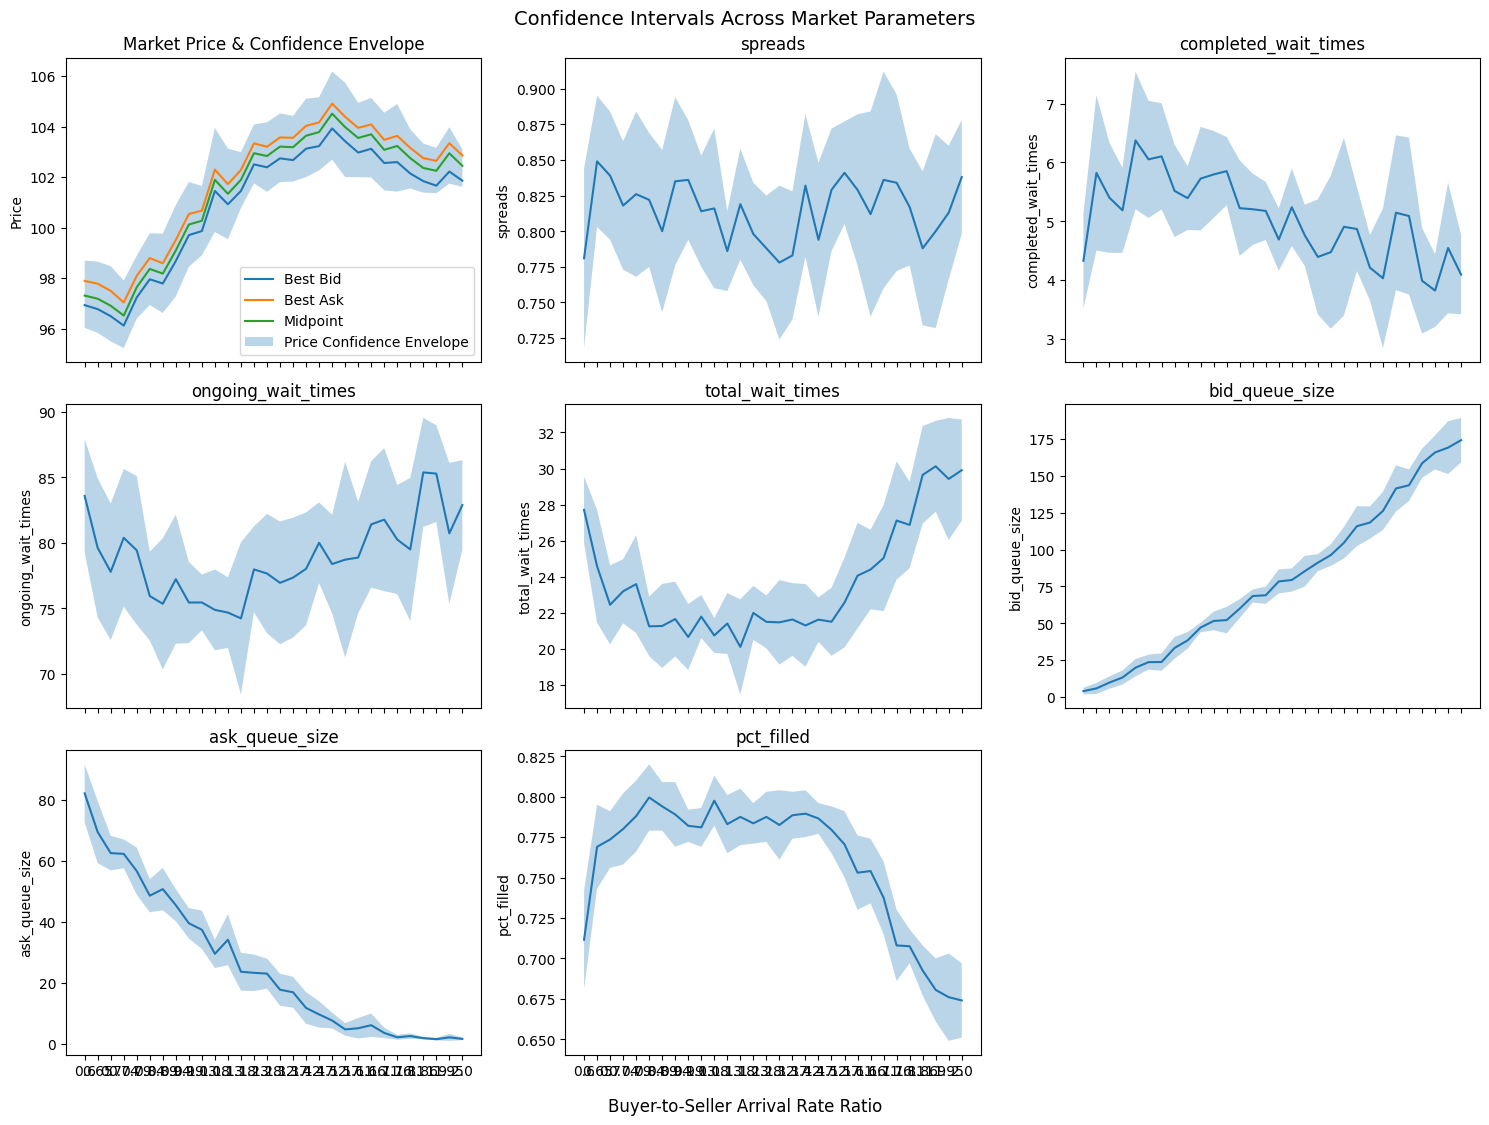

In [90]:
import math
def plot_ci_subplots_with_price_envelope(ci_results_df, ncols=3):
    """
    ci_results_df:
        rows    -> metrics
        columns -> buyer/seller ratios
        values  -> [low, high]
    """

    ratios = np.array(sorted(ci_results_df.columns))

    # Metrics
    price_metrics = ["best_bids", "best_asks", "midpoints"]
    other_metrics = [m for m in ci_results_df.index if m not in price_metrics]

    # Total number of panels (+1 for price envelope)
    n_panels = 1 + len(other_metrics)
    nrows = math.ceil(n_panels / ncols)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(5 * ncols, 3.8 * nrows),
        sharex=True
    )

    axes = np.array(axes).reshape(-1)

    # --------------------------------------------------
    # 1. PRICE ENVELOPE PANEL
    # --------------------------------------------------
    ax = axes[0]

    bid_low, bid_mid = [], []
    ask_high, ask_mid = [], []
    mid_mid = []

    for r in ratios:
        b_low, b_high = ci_results_df.loc["best_bids", r]
        a_low, a_high = ci_results_df.loc["best_asks", r]
        m_low, m_high = ci_results_df.loc["midpoints", r]

        bid_low.append(b_low)
        bid_mid.append((b_low + b_high) / 2)

        ask_high.append(a_high)
        ask_mid.append((a_low + a_high) / 2)

        mid_mid.append((m_low + m_high) / 2)

    bid_low = np.array(bid_low)
    ask_high = np.array(ask_high)

    ax.plot(ratios, bid_mid, label="Best Bid")
    ax.plot(ratios, ask_mid, label="Best Ask")
    ax.plot(ratios, mid_mid, label="Midpoint")

    ax.fill_between(
        ratios,
        bid_low,
        ask_high,
        alpha=0.3,
        label="Price Confidence Envelope"
    )

    ax.set_title("Market Price & Confidence Envelope")
    ax.set_ylabel("Price")
    ax.legend()

    # --------------------------------------------------
    # 2. OTHER METRICS (STANDARD CI PANELS)
    # --------------------------------------------------
    for ax, metric in zip(axes[1:], other_metrics):
        lows, highs, mids = [], [], []

        for r in ratios:
            low, high = ci_results_df.loc[metric, r]
            lows.append(low)
            highs.append(high)
            mids.append((low + high) / 2)

        ax.plot(ratios, mids)
        ax.fill_between(ratios, lows, highs, alpha=0.3)
        ax.set_title(metric)
        ax.set_ylabel(metric)

    # Remove unused axes
    for ax in axes[n_panels:]:
        ax.remove()

    fig.supxlabel("Buyer-to-Seller Arrival Rate Ratio")
    fig.suptitle("Confidence Intervals Across Market Parameters", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_ci_subplots_with_price_envelope(ratio_ci_results)